# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup, draw_jointplot
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Load Dataset

In [5]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
    {
            'subgroup_col_name': 'SEX',
            'n': 25000,
            'correlation_by_subgroup_values': [i, j],
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, round(-1-k, 2)) for k in [-0.7, -0.65, -0.6, -0.55, -0.5, -0.45, -0.4, -0.35, -0.3][:]]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][-1:]}

In [6]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    correlations = [round(-get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, {'SEX': i}), 2) for i in [0, 1]]
    print(f"Correlation between sensitive attribute and output for subgroup 0: {correlations[0]}, for subgroup 1: {correlations[1]}")

Correlation between sensitive attribute and output for subgroup 0: 0.7, for subgroup 1: 0.3
Correlation between sensitive attribute and output for subgroup 0: 0.65, for subgroup 1: 0.35
Correlation between sensitive attribute and output for subgroup 0: 0.6, for subgroup 1: 0.4
Correlation between sensitive attribute and output for subgroup 0: 0.55, for subgroup 1: 0.45
Correlation between sensitive attribute and output for subgroup 0: 0.5, for subgroup 1: 0.5
Correlation between sensitive attribute and output for subgroup 0: 0.45, for subgroup 1: 0.55
Correlation between sensitive attribute and output for subgroup 0: 0.4, for subgroup 1: 0.6
Correlation between sensitive attribute and output for subgroup 0: 0.35, for subgroup 1: 0.65
Correlation between sensitive attribute and output for subgroup 0: 0.3, for subgroup 1: 0.7


# Train/Load Model

In [7]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subgroup_values_[-0.7, -0.3]_rs42
Loaded classifier for experiment from file: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subgroup_values_[-0.7, -0.3]_rs42
Training classifier for experiment: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subgroup_values_[-0.65, -0.35]_rs42
Loaded classifier for experiment from file: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subgroup_values_[-0.65, -0.35]_rs42
Training classifier for experiment: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subgroup_values_[-0.6, -0.4]_rs42
Loaded classifier for experiment from file: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subgroup_values_[-0.6, -0.4]_rs42
Training classifier for experiment: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subgroup_values_[-0.55, -0.45]_rs42
Loaded classifier for experiment from file: Census19_subgroup_col_name_SEX_n_25000_correlation_by_subg

# Launch Attribute Inference Attacks

In [8]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)

# Plot Results

In [9]:
from experiment_utils import eval_func, metrics

In [15]:
metric_='accuracy'
performance_dict = {}
for attack in ['CSMIA', 'LOMIA']:
    performance_dict[attack] = {}
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        correlation = round(get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, {'SEX': 0}), 2)
        performance_dict[attack][correlation] = {}
        for subgroup_val in [0, 1]:
            indices = get_indices_by_group_condition(experiment.X_train, {'SEX': subgroup_val})
            performance_dict[attack][correlation][['Male', 'Female'][subgroup_val]] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], {'CSMIA': experiment.sens_pred_CSMIA, 'LOMIA': experiment.sens_pred_LOMIA}[attack][indices]) for metric in metrics}[metric_]

In [17]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 15

def plot_result(performance_dict, attack='CSMIA'):
    df = pd.DataFrame.from_dict(performance_dict[attack], orient='index')
    df.index.name = 'Correlation'
    df.reset_index(inplace=True)
    fig, ax = plt.subplots(figsize=(10, 3))
    plt.grid(True, linewidth=0.25, axis='y')
    width = 0.012
    colors = ['#FFFFFF', '#D3D3D3']

    plt.bar(df['Correlation'] -0.002 - width/2, df['Male'], width, label='Male', alpha=1, color=colors[0], hatch='..', edgecolor='black', linewidth=1.5, bottom=-10, zorder=2)
    plt.bar(df['Correlation'] +0.002 + width/2, df['Female'], width, label='Female', alpha=1, color=colors[1], hatch='////', edgecolor='black', linewidth=1.5, bottom=-10, zorder=2)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=2)
    ax.set_xlabel('Correlation of Male Group')
    ax.set_ylabel('Attack Accuracy (%)')
    ax.set_xticks(df['Correlation'])
    ax.set_xticklabels(df['Correlation'])
    ax.set_ylim(50, 100)
    ax_top = ax.twiny()

    # Set xticks at top
    ax_top.set_xlabel('Correlation of Female Group')
    ax_top.set_xticks(df['Correlation'])
    ax_top.set_xticklabels([round(-1 - tick, 2) for tick in df['Correlation']])

    # Align the secondary x-axis with the bottom x-axis
    ax_top.set_xlim(ax.get_xlim())
    plt.show()

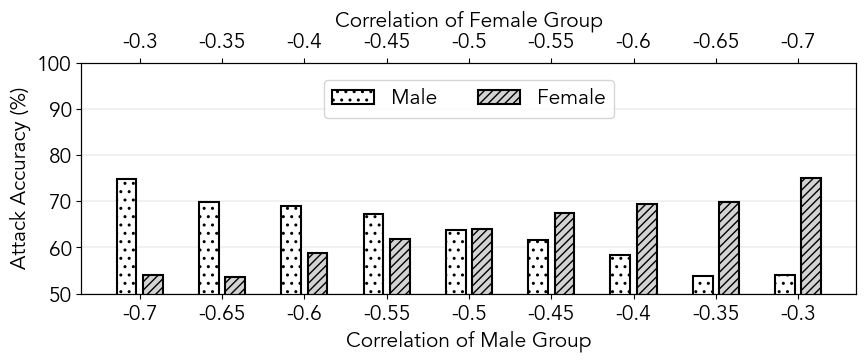

In [18]:
plot_result(performance_dict)

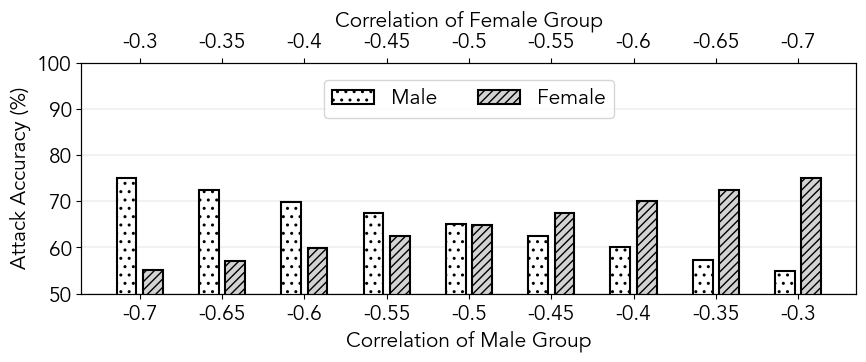

In [19]:
plot_result(performance_dict, 'LOMIA')

# Plot Angular Difference

In [20]:
experiment = experiments['corr_btn_sens_and_out_(-0.6, -0.4)']
experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_tr, experiment.clf)
sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
case_2_indices = case_indices[2]
experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]
experiment.sens_pred_CSMIA = sens_pred

Correlation between sensitive attribute and output for subgroup sex=Male: -0.6


<Figure size 500x600 with 0 Axes>

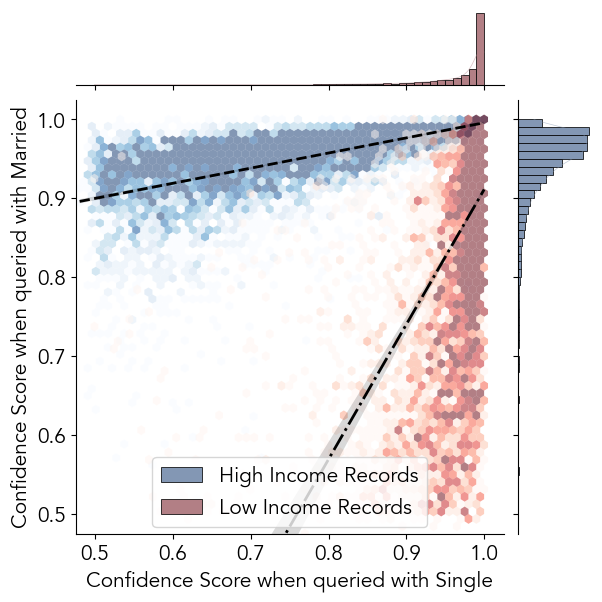

Correlation between sensitive attribute and output for subgroup race=White: -0.5


<Figure size 500x600 with 0 Axes>

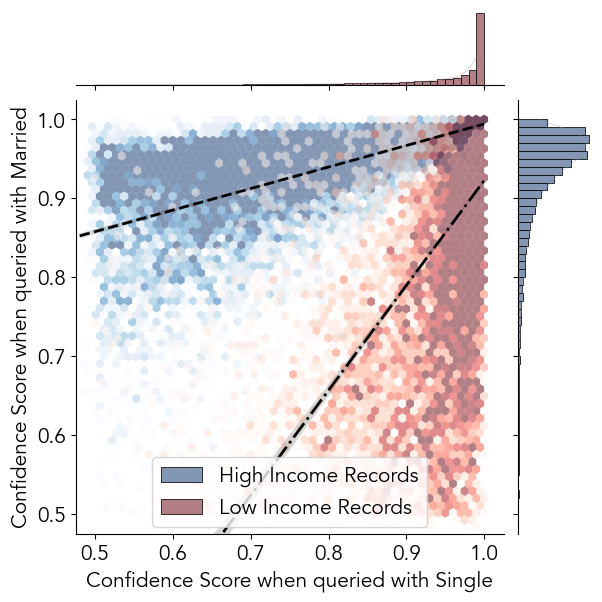

Correlation between sensitive attribute and output for subgroup sex=Female: -0.4


<Figure size 500x600 with 0 Axes>

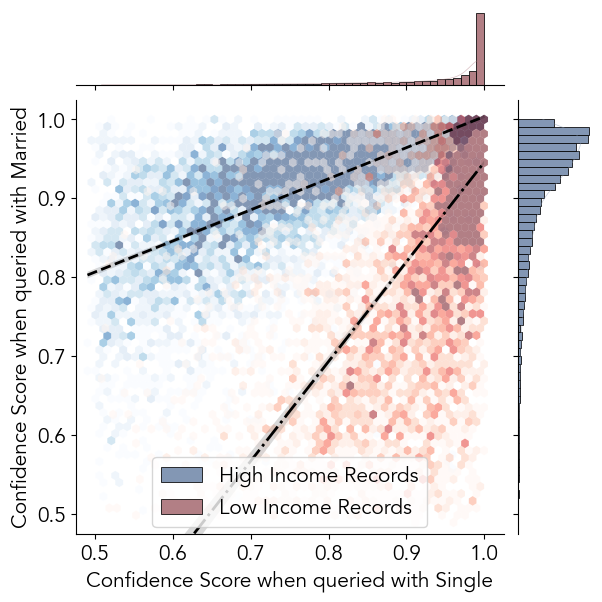

In [25]:
conditions =  [{'SEX': 0}] + [{'RAC1P': 0}] + [{'SEX': 1}]
correlations = [round(get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition), 2) for condition in conditions]
subgroup_names = ['sex=Male', 'race=White', 'sex=Female']
for i, condition in enumerate(conditions):
    print(f"Correlation between sensitive attribute and output for subgroup {subgroup_names[i]}: {correlations[i]}")
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    draw_jointplot(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
    plt.show()